In [1]:
%matplotlib inline
# imports required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pynetlogo
import numpy as np
import sys
sys.path.append('../')

from LandLab_experiments.ecohydr_mod import EcoHyd

In [2]:
def get_yearly_temp(csv_path, num_years):
    df = pd.read_csv(csv_path)
    df.dt = pd.to_datetime(df.dt)
    avg_temp_per_year = []
    max_temp_per_year = []
    min_temp_per_year = []
    for year in range(0, num_years):
        earliest_yr = df.iloc[0, 0].year
        year = year + earliest_yr
        if len(df.loc[(df.dt.dt.year == year), :]) > 365:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].iloc[:-1].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].iloc[:-1].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].iloc[:-1].tolist())
        else:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].tolist())
    
    return avg_temp_per_year, max_temp_per_year, min_temp_per_year

yearData = get_yearly_temp("/Users/mabelwylie/Documents/NetLogo-MOSS-Python/CouplingRepo/TreesAndThat/LandLab_experiments/new_temp_data.csv", 10)

In [3]:
def setUpNetLogoModel(leadFarmers, desperation, jealousy, grace):
    # think this is for the GUI idk?
    sns.set_style("white")
    sns.set_context("talk")

    # starts a NetLogo link, point the netlogo home path to where you have it installed on your machine
    netlogo = pynetlogo.NetLogoLink(
        gui=False,
        netlogo_home="/Volumes/NetLogo 6.3.0/NetLogo 6.3.0"
    )

    # loads a .nlogo model from provided path
    netlogo.load_model("/Users/mabelwylie/Documents/NetLogo-MOSS-Python/CouplingRepo/TreesAndThat/Coupling/modelv2.nlogo")

     # sets globals
    globals = "update-globals " + str(leadFarmers) + " " + str(desperation) + " " + str(jealousy) + " " + str(grace)
    #netlogo.command(globals)
    
    # runs the model setup command
    netlogo.command("setup")

    return netlogo

In [4]:
def reportsToDataFrame(netlogo):
    # gets field attributes and puts it in a data frame
    fieldAttributes = netlogo.report("get-info")
    sorted_list = sorted(fieldAttributes, key=lambda x: (-x[1],x[0]))
    fieldData = pd.DataFrame(columns=["who", "xcor","ycor","owner-id","implements-WSA", "yield"], data=sorted_list)
    return fieldData

In [5]:
def convertWSAToNPArray(data):
    # sets bool into correct format to pass to hydrology model
    emptynp = np.empty((51,51))
    for i in range(0,51):
        for j in range(0,51):
            ycorFromIndex = i * -1 + 25
            xcorFromIndex = j - 25
            emptynp[i][j]= data.loc[(data['ycor'] == ycorFromIndex) & (data['xcor'] == xcorFromIndex)]["implements-WSA"].iloc[0]
    return emptynp

In [6]:
def convertHydrologyToDF(hydrologyArray, data):
    # method converts the hydrology model output into a pandas dataframer
    # 2 is the placeholder to multiply the biomass to get yield
    hydrologyData = data.copy()
    hydrologyData["yield"] = hydrologyArray.reshape((2601,1))
    return hydrologyData

year: 0
converted to NP array
0
0
0
0
1
0.0027397260273972603
2
0.005479452054794521
3
0.008219178082191782
4
0.010958904109589041
5
0.0136986301369863
5
0.01643835616438356
6
0.01917808219178082
7
0.02191780821917808
8
0.02465753424657534
9
0.027397260273972598
10
0.030136986301369857
11
0.03287671232876712
13
0.03561643835616438
14
0.038356164383561646
15
0.04109589041095891
16
0.04383561643835617
17
0.046575342465753435
18
0.0493150684931507
19
0.05205479452054796
20
0.05479452054794522
21
0.057534246575342486
22
0.06027397260273975
23
0.063013698630137
24
0.06575342465753427
25
0.06849315068493153
26
0.0712328767123288
27
0.07397260273972606
28
0.07671232876712332
29
0.07945205479452058
30
0.08219178082191785
31
0.08493150684931511
32
0.08767123287671237
33
0.09041095890410963
34
0.0931506849315069
35
0.09589041095890416
36
0.09863013698630142
37
0.10136986301369869
38
0.10410958904109595
39
0.10684931506849321
40
0.10958904109589047
41
0.11232876712328774
42
0.115068493150685
43
0

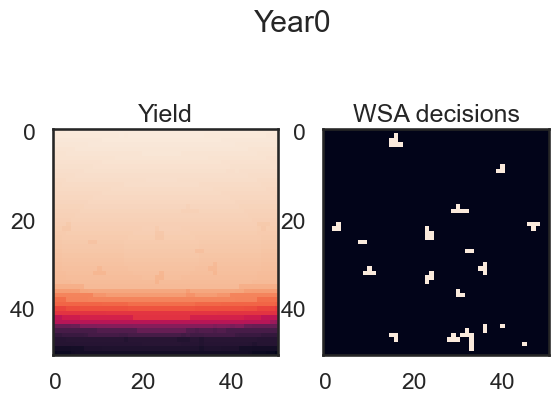

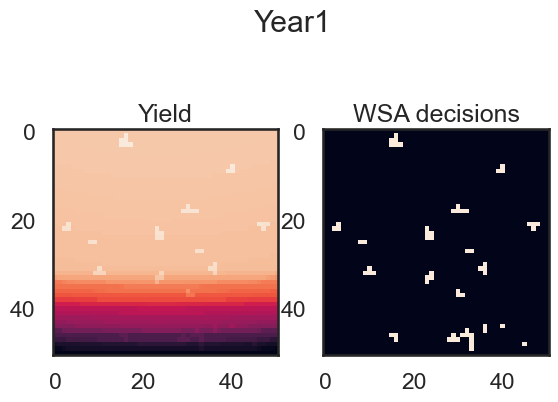

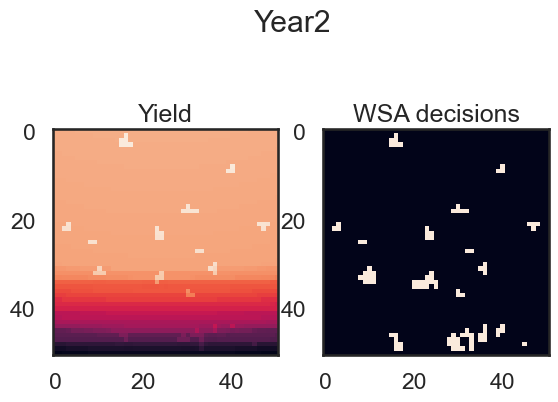

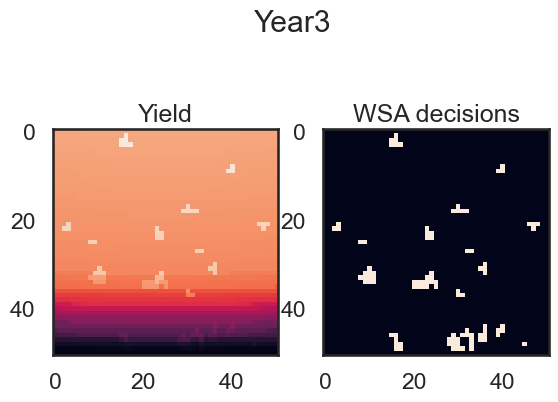

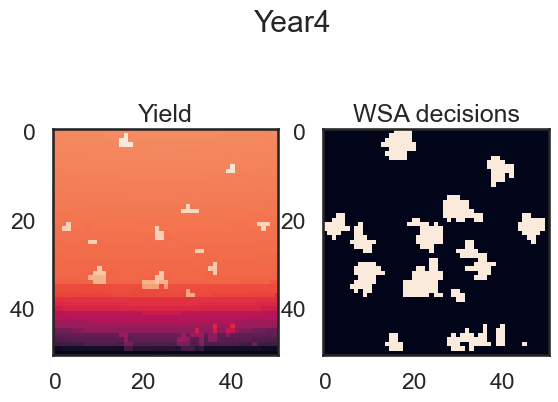

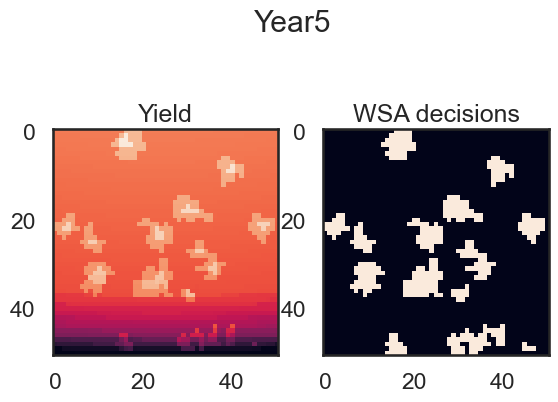

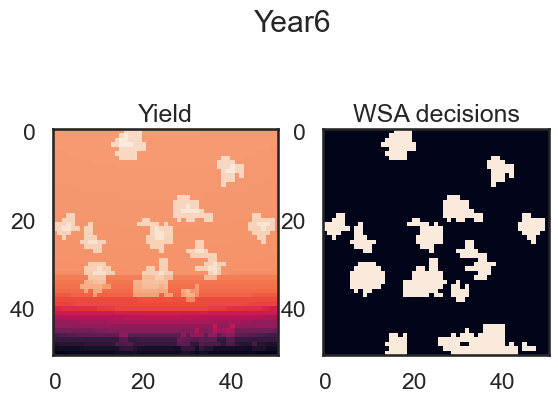

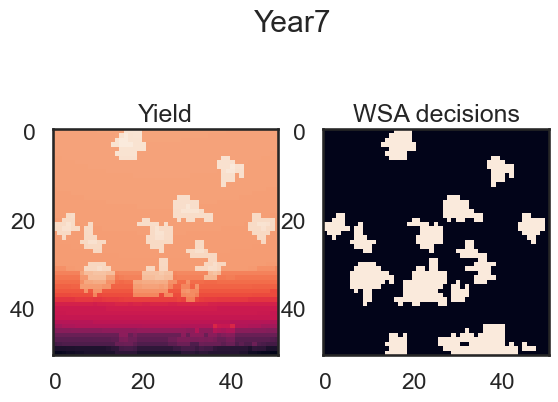

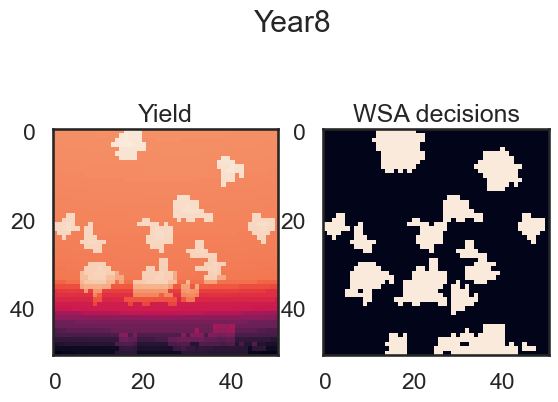

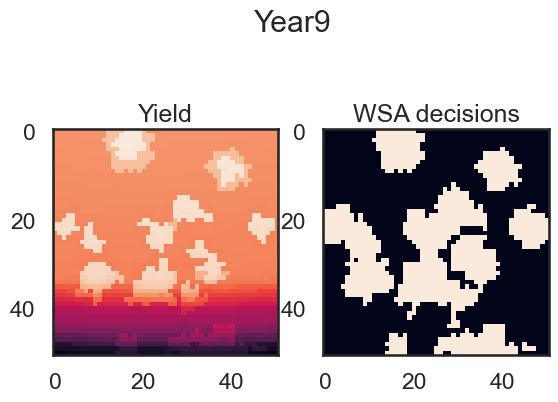

In [7]:
def fullModelRun(leadFarmers, desperation, jealousy, grace, fileSuffix, input_csv_path, no_of_years):
    # sets up model
    netlogo = setUpNetLogoModel(leadFarmers, desperation, jealousy, grace)

    # this will record all field attributes throughout the simulation - need to add year index to differentiate
    baseFieldData = reportsToDataFrame(netlogo)

    returnedData = baseFieldData.copy()
    
    baseFieldData["Year"] = 0

    WSA_records = []


    #get input temperature data
    avg, maxi, mini = get_yearly_temp(input_csv_path, no_of_years)

    Ecohyd_model = EcoHyd(20, 26, 23)

    for year in range(0, no_of_years):
        print("year:", year)

        # converts the usingWSA bool for each field into an NP array
        WSA_array = convertWSAToNPArray(returnedData)
        WSA_records.append([WSA_array])
        print("converted to NP array")

        biomass_harvest, SM_canic_end = Ecohyd_model.stepper(WSA_array, avg[year], maxi[year], mini[year])
        #hydrologyOutput = hydrologyModelYear(WSA_array)
        
        print(biomass_harvest)

        fig, ax = plt.subplots(1, 2)
        title_string = "Year" + str(year)
        fig.suptitle(title_string)
        ax[0].imshow(np.reshape(biomass_harvest,(51,51)))
        ax[0].set_title("Yield")
        ax[1].imshow(WSA_array)
        ax[1].set_title("WSA decisions")

        returnedData.sort_values(by=['ycor', 'xcor'], ascending=[False, True], inplace=True)
        print(returnedData)
        # converts the updated yields to the dataframe
        hydrologyData = convertHydrologyToDF(biomass_harvest,returnedData)
        print("Converted output to df")

        print(hydrologyData)
        # writes this new yield information to the netlogo implementation
        netlogo.write_NetLogo_attriblist(hydrologyData, "field")
        print("wrote to netlogo")

        # runs one step of social model
        netlogo.command("farming-year")
        print("farming command")

        # converts field data to a df
        returnedData = reportsToDataFrame(netlogo)
        print("convertedtoDF")

        dataToRecord = returnedData.copy()
        
        dataToRecord["Year"] = year + 1

        # adds this years results to the dataframe
        baseFieldData = pd.concat([baseFieldData, dataToRecord], ignore_index=True)

    return baseFieldData, WSA_records, biomass_harvest
    

        

## dummy hydrology model to test running
def hydrologyModelYear(input):
    print("One year yield")
    return 100 * np.ones((51,51))

# haven't got setup with globals actually working yet, manually change in the NetLogo Code
baseFieldData, WSA_records, biomass_harvest = fullModelRun(20, 50, 50, 3, 2, "new_temp_data.csv", 10)

In [8]:
baseFieldData.loc[(baseFieldData["implements-WSA"] == 0) & (baseFieldData["Year"] == 3) & (baseFieldData["yield"] > 30)]

,who,xcor,ycor,owner-id,implements-WSA,yield,Year


In [9]:
biomass_harvest

array([ 24.19282508,  24.19846567,  24.20388303, ...,   7.44647898,
         7.20533708,   7.20270539])

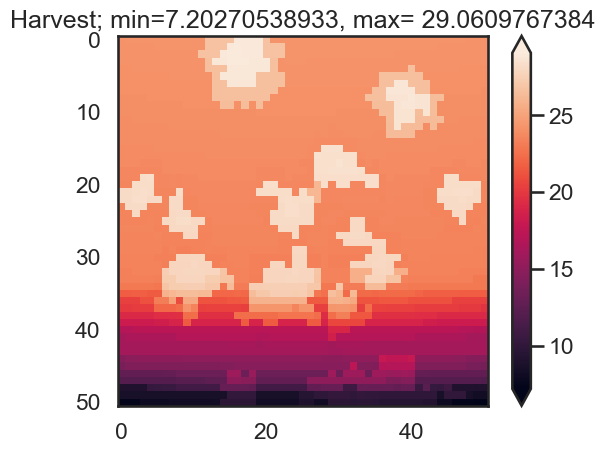

In [10]:
plt.imshow(np.reshape(biomass_harvest, (51,51)))
hmin = np.min(biomass_harvest)
hmax = np.max(biomass_harvest)
plt.title('Harvest; min='+str(hmin)+', max= ' + str(hmax))

plt.colorbar(extend = 'both')

In [11]:
print(baseFieldData.loc[baseFieldData["implements-WSA"] == 1].groupby(["Year"]).mean())

              who      xcor      ycor    owner-id  implements-WSA      yield
Year                                                                        
0     1978.634921  1.603175 -3.984127  460.476190             1.0  50.000000
1     1978.634921  1.603175 -3.984127  460.476190             1.0  29.126250
2     2042.360825  0.463918 -8.113402  387.948454             1.0  40.977790
3     2042.360825  0.463918 -8.113402  387.948454             1.0  24.932573
4     2053.960526 -0.365789 -1.005263  369.478947             1.0  39.145083
5     2060.298765 -0.096296 -2.224691  372.118519             1.0  28.008284
6     2054.598684  0.434211 -4.131579  380.497807             1.0  32.011529
7     2065.914286  0.204082 -4.646939  389.789796             1.0  32.032158
8     2074.102894  0.479100 -1.368167  398.250804             1.0  36.616872
9     2077.421842 -0.041756 -1.079229  409.716274             1.0  35.418197
10    2077.421842 -0.041756 -1.079229  409.716274             1.0  23.974228

In [12]:
print(baseFieldData.groupby(["Year", "implements-WSA"]).mean())

                             who      xcor      ycor    owner-id      yield
Year implements-WSA                                                        
0    0.0             2103.012608 -0.039795  0.098897  401.624901  50.000000
     1.0             1978.634921  1.603175 -3.984127  460.476190  50.000000
1    0.0             2103.012608 -0.039795  0.098897  401.624901  31.792248
     1.0             1978.634921  1.603175 -3.984127  460.476190  29.126250
2    0.0             2102.232827 -0.017971  0.314297  403.635383  44.420383
     1.0             2042.360825  0.463918 -8.113402  387.948454  40.977790
3    0.0             2102.232827 -0.017971  0.314297  403.635383  26.071727
     1.0             2042.360825  0.463918 -8.113402  387.948454  24.932573
4    0.0             2107.877082  0.062584  0.171995  408.794237  36.383107
     1.0             2053.960526 -0.365789 -1.005263  369.478947  39.145083
5    0.0             2107.321949  0.017760  0.410291  408.755009  27.189516
     1.0    

Text(0.5, 0.98, 'WSA field spread')

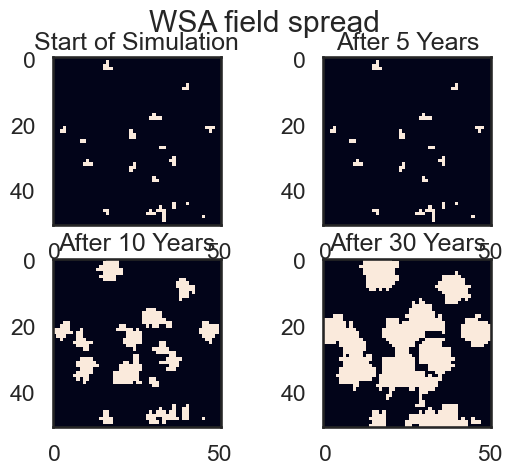

In [13]:
fig, ax = plt.subplots(2, 2)
ax[0][0].imshow(WSA_records[0][0])
ax[0][0].set_title("Start of Simulation")
ax[0][1].imshow(WSA_records[1][0])
ax[0][1].set_title("After 5 Years")
ax[1][0].imshow(WSA_records[4][0])
ax[1][0].set_title("After 10 Years")
ax[1][1].imshow(WSA_records[9][0])
ax[1][1].set_title("After 30 Years")
plt.suptitle("WSA field spread")

Text(0.5, 1.0, 'Average farmer yield by WSA type')

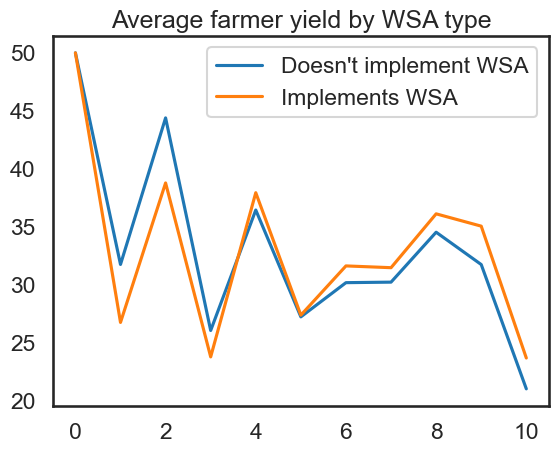

In [14]:
avgyielddata = baseFieldData.groupby(["Year", "owner-id"]).mean().reset_index().groupby(["Year","implements-WSA"]).mean().reset_index()

nonImp = avgyielddata.loc[avgyielddata["implements-WSA"] == 0]
imp = avgyielddata.loc[avgyielddata["implements-WSA"] == 1]

plt.plot(nonImp["Year"], nonImp["yield"], label = "Doesn't implement WSA")
plt.plot(imp["Year"], imp["yield"], label = "Implements WSA")
plt.legend()
plt.title("Average farmer yield by WSA type")

Text(0.5, 1.0, 'Number of farmers using each technique')

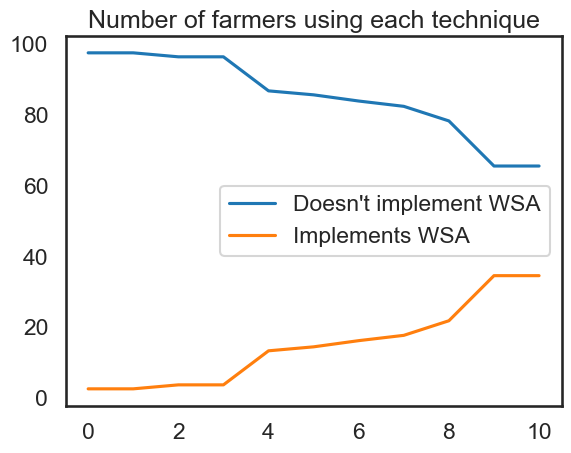

In [15]:
proportionData = baseFieldData.groupby(["Year","implements-WSA","owner-id"]).mean().reset_index().groupby(["Year","implements-WSA"])["yield"].count().reset_index()

proportionData["percentage"] = proportionData["yield"] / 800 * 100

nonImp = proportionData.loc[proportionData["implements-WSA"] == 0]
imp = proportionData.loc[proportionData["implements-WSA"] == 1]

plt.plot(nonImp["Year"], nonImp["percentage"], label = "Doesn't implement WSA")
plt.plot(imp["Year"], imp["percentage"], label = "Implements WSA")
plt.legend()
plt.title("Number of farmers using each technique")